In [3]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

import datetime
from sys import getsizeof,path

import matplotlib.pyplot as plt
import matplotlib

path.append("../src")
from Splines import CentripetalCatmullRomSpline_splitControls,Spline

import pymc3 as pm
import theano
import theano.tensor as tt


theano.config.gcc_cxxflags = "-Wno-c++11-narrowing"

import arviz as az

# Simple Example - recover control Params

Test values in 5.079s


Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 6100
Interrupted at 6,099 [3%]: Average Loss = 78.019
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, est_control, sigma_control]


Sampling 4 chains for 400 tune and 400 draw iterations (1_600 + 1_600 draws total) took 134 seconds.
The number of effective samples is smaller than 25% for some parameters.


Compiled and Sampled in 212.798


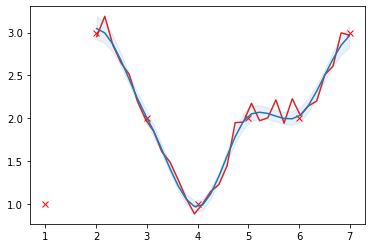

In [2]:
coords = {"cpx":np.array([1,2,3,4,5,6,7],"float64"),"space":np.linspace(2.01,6.99,32,"float64")}
test_control = np.array([1,3,2,1,2,2,3],"float64")
test_spline = Spline(coords["cpx"],tt.cast(test_control,"float64").reshape((1,test_control.shape[0],)))

t1 = time.time()
test_values = test_spline.EvaluateAt(coords["space"]).eval()[:,0]
test_values += np.random.normal(0, .1, coords["space"].shape[0])
t2 = time.time()
print("Test values in %.3fs"%(t2-t1))

plt.plot(coords["space"],test_values,color="tab:red")
plt.plot(coords["cpx"],test_control,"rx")

with pm.Model(coords=coords) as model:
    
    sigma_control = pm.Lognormal("sigma_control",mu=tt.log(2),sigma=1.)
    
    est_control = pm.Normal("est_control",mu=0,sigma=sigma_control,dims=("cpx"))
    est_control = tt.exp(tt.cumsum(est_control))
    
    est_spline = Spline(coords["cpx"],est_control.reshape((1,test_control.shape[0],)))
    est_values = est_spline.EvaluateAt(coords["space"])[:,0]
    
    pm.Deterministic("est_values",est_values)

    sigma_obs = pm.HalfCauchy(name="sigma_obs",beta=2)
    pm.StudentT("est",nu=4,sigma=tt.abs_(est_values+1.)**.5 * sigma_obs,mu=est_values,observed=test_values)
    
    trace = pm.sample(init="advi",return_inferencedata=True,tune=400,draws=400,cores=4,chains=4,max_treedepth=12,target_accept=.95)

t3 = time.time()
print("Compiled and Sampled in %.3f"%(t3-t2))

q = trace.posterior["est_values"].quantile((0.5,.05,.95),["chain","draw"])
plt.plot(coords["space"],q[0],color="tab:blue")
plt.fill_between(coords["space"],q[1],q[2],alpha=.1,color="tab:blue")

array([[<AxesSubplot:title={'center':'est_control'}>,
        <AxesSubplot:title={'center':'est_control'}>]], dtype=object)

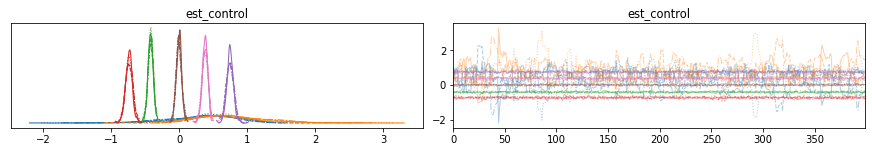

In [4]:
az.plot_trace(trace.posterior["est_control"])

array([[<AxesSubplot:title={'center':'sigma_control'}>,
        <AxesSubplot:title={'center':'sigma_control'}>]], dtype=object)

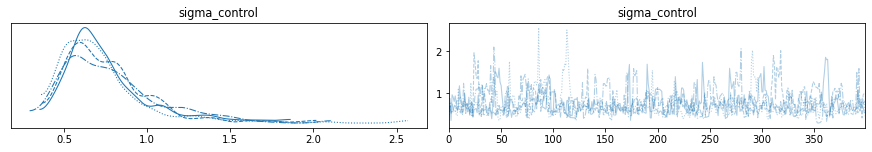

In [5]:
az.plot_trace(trace.posterior["sigma_control"])

array([[<AxesSubplot:title={'center':'sigma_obs'}>,
        <AxesSubplot:title={'center':'sigma_obs'}>]], dtype=object)

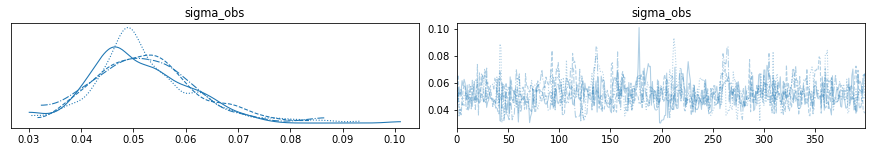

In [6]:
az.plot_trace(trace.posterior["sigma_obs"])

# SEIR Model with R_eff from Spline

In [49]:
coords = {"cpx":np.linspace(0,70,8,"float64"),"space":np.linspace(10,50,41,"float64")}
rtest_control = np.array([3,5,6,2,.9,.9,1.1,1.2],"float64")
rtest_spline = Spline(coords["cpx"],tt.cast(rtest_control,"float64").reshape((1,rtest_control.shape[0],)))


t1 = time.time()
rtest_tvalues = rtest_spline.EvaluateAt(coords["space"])[:,0]
rtest_values = rtest_tvalues.eval()
rtest_values += np.random.normal(0, .1, coords["space"].shape[0])
t2 = time.time()
print("Test values in %.3fs"%(t2-t1))


Test values in 5.381s


In [50]:
def tt_lognormal(x, mu, sigma):
# Limit to prevent NANs
    x = tt.clip(x,1e-9,1e12)
    sigma = tt.clip(sigma,1e-9,1e12)
    mu = tt.clip(mu,1e-9,1e12)
    
    distr = 1/x * tt.exp( -( (tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0) + 1e-12)

def SEIR_model(N, imported_t,Reff_t, median_incubation,sigma_incubation,l=32):
    N = tt.cast(N,'float64')
    beta = tt_lognormal(tt.arange(l), tt.log(median_incubation), sigma_incubation)
    
    # Dirty hack to prevent nan - seems not needed if priors are better
 #   beta = tt.alloc(0,l)
  #  beta = tt.set_subtensor(beta[tt.clip(tt.cast(median_incubation,'int32'),1,l-2)],1)
     
    Reff_t = tt.as_tensor_variable(Reff_t)
    imported_t = tt.as_tensor_variable(imported_t)

    def new_day(Reff_at_t,imported_at_t,infected,E_t,beta,N):
        f = E_t / N
     #   f = 1
        new = imported_at_t + tt.dot(infected,beta) * Reff_at_t * f
        new = tt.clip(new,0,N)
     
        infected = tt.roll(infected,1,0)
        infected = tt.set_subtensor(infected[:1],new,inplace=False)
        E_t = tt.clip(E_t-new,0,E_t)
#        E_t = E_t-new
        return new,infected,E_t
    
    outputs_info = [None,np.zeros(l),N]
    infected_t,updates = theano.scan(fn=new_day,
                                     sequences=[Reff_t,imported_t],
                                     outputs_info=outputs_info,
                                     non_sequences=[beta,N],
                                     profile=False)
                                     
    return infected_t

[4.95423049 5.16137139 5.34581178 5.33446427 5.37436395 5.75191548
 6.14268506 6.31111426 6.23725236 6.13640658 5.96225937 5.8740135
 5.48847258 5.07915407 4.61309405 4.23086426 3.62561512 3.16052012
 2.61295966 2.26302411 2.25672053 1.91813928 1.75864318 1.50078042
 1.47737919 1.10351055 1.25342439 0.97332606 1.04034797 0.93743298
 0.87440996 0.75364989 0.78599719 0.68581787 0.66926067 0.72510823
 0.7558156  0.95201675 0.90191117 0.94517687 0.7429122 ]
[  6.           6.           4.00000077   2.02605836   2.01692608
   5.68186607  13.82990328  20.53537839  22.14172348  20.97389776
  22.33298413  32.28818794  48.410325    64.83136422  74.59092208
  80.04835053  81.02913701  89.09231442  96.71840759 107.83180708
 131.10803908 128.41042395 130.74310042 122.02080114 131.69161657
 109.03292679 136.40110262 113.73717053 126.68584311 116.29912692
 108.52486891  93.33727087  97.06450977  84.31985868  81.49130247
  86.1578536   85.92529189 102.3882048   91.25794571  89.96622587
  67.38310945]

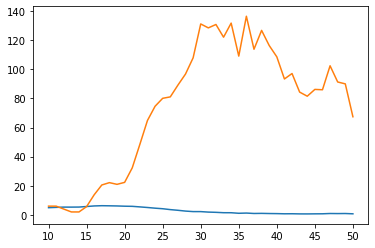

In [51]:
initial = tt.zeros_like(rtest_tvalues)
initial = tt.set_subtensor(initial[:5],tt.cast([6,6,4,2,1],"float64"))

new,infected,E_t = SEIR_model(83e8,initial,rtest_values,6,.3)

new_infected = new.eval()

print(rtest_values)
print(new_infected)

plt.plot(coords["space"],rtest_values)
plt.plot(coords["space"],new_infected)

In [ ]:
with pm.Model(coords=coords) as model:
    
    sigma_control = pm.Lognormal("sigma_control",mu=tt.log(2),sigma=1.)
    
    est_control = pm.Normal("est_control",mu=0,sigma=sigma_control,dims=("cpx"))
    est_control = tt.exp(tt.cumsum(est_control))
    
    est_spline = Spline(coords["cpx"],est_control.reshape((1,coords["cpx"].shape[0],)))
    est_values = est_spline.EvaluateAt(coords["space"])[:,0]
    
    est_new,est_infected,est_E_t = SEIR_model(83e8,initial,est_values,6,.3)
    
    pm.Deterministic("est_control_sum",est_control)
    pm.Deterministic("est_values",est_values)
    pm.Deterministic("est_new",est_new)

    sigma_obs = pm.HalfCauchy(name="sigma_obs",beta=2)
    pm.StudentT("est",nu=4,sigma=tt.abs_(est_new+1.)**.5 * sigma_obs,mu=est_new,observed=new_infected)
    
    trace = pm.sample(init="advi",return_inferencedata=True,tune=200,draws=200,cores=4,chains=4,max_treedepth=12,target_accept=.95)

t3 = time.time()
print("Compiled and Sampled in %.3f"%(t3-t2))

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


In [ ]:
q = trace.posterior["est_control_sum"].quantile((0.5,.05,.95),["chain","draw"])

plt.plot(coords["cpx"],q[0])
plt.fill_between(coords["cpx"],q[1],q[2],alpha=.1)

print(q)
plt.plot(coords["cpx"],rtest_control,"rx")

In [ ]:
az.plot_trace(trace.posterior["est_control"])

In [ ]:
q = trace.posterior["est_new"].quantile((0.5,.05,.95),["chain","draw"])

plt.plot(coords["space"],q[0])
plt.fill_between(coords["space"],q[1],q[2],alpha=.1)

print(q)
plt.plot(coords["space"],new_infected,"rx")

In [ ]:
az.plot_trace(trace.posterior["sigma_control"])

In [ ]:
az.plot_trace(trace.posterior["sigma_obs"])